# <ins> Project 1: </ins> 
### Using regression tools to analyze COVID 19 data at the County level for multiple States in the US

***
### Academic honesty statement

**SANTIAGO ORTIZ LAVERDE**

- I state that I worked alone on this assignment. Therefore, I take full responsibility for the academic integrity of the work presented below.
***

### File name *(1) data_pre-processing.ipynb*
- Raw data is filtered and consolidated in DataFrames for further analysis.

In [1]:
import pandas as pd
import seaborn as sns; sns.set(); sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import numpy as np

#### 1. Import and convert .cvs files (raw data) to pandas DataFrames.

In [2]:
# Education estimates from 2019 at the county level throughout the United States.
raw_edu = pd.read_csv('data/Education/education_data_2019.csv')
# Income (total household) estimates from 2019 at the county level throughout the United States.
raw_inco = pd.read_csv('data/Income/income_data_2019.csv')
# Total population census from 2020 at the county level throughout the United States.
raw_popul_20 = pd.read_csv('data/Population/population_2020.csv', encoding='iso-8859-1')
# COVID-19 data from 2020 and 2021 at the county level.
raw_covid_20 = pd.read_csv('data/COVID-19/US_COVID-19_2020.csv', encoding='iso-8859-1')
raw_covid_21 = pd.read_csv('data/COVID-19/US_COVID-19_2021.csv', encoding='iso-8859-1')

#### 2. Filter, group and consolidate data from Pandas DataFrames.

In [3]:
df_dict = {}
states = ['California', 'Florida', 'New York']
sts = ['CA', 'FL', 'NY']

for state, st in zip(states, sts):
    # Filter population data by State name.
    popul_df = raw_popul_20[raw_popul_20['State'] == state]
    st_popul = popul_df['Estimate'].sum()
    # Filter Education and Income data by State name.
    edu_df = raw_edu[raw_edu['State'] == state]
    inco_df = raw_inco[raw_inco['State'] == state]
    # Filter COVID-19 data by State name and specific date for 2020 and 2021.
    covid_20df = raw_covid_20[raw_covid_20['State'] == state]
    covid_20_df = covid_20df[covid_20df['date'] == '12/31/2020'].reset_index(drop=True)
    covid_21df = raw_covid_21[raw_covid_21['State'] == state]
    covid_21_df = covid_21df[covid_21df['date'] == '2021-12-31'].reset_index(drop=True)
    covid_20_df['County'] = covid_21_df['County']
    # Store filtered DataFrames in dictionary.
    df_dict[st] = [popul_df, edu_df, inco_df, covid_20_df, covid_21_df]
    # Find lower number of counties. 
    len_dfs = [len(popul_df), len(edu_df), len(inco_df), len(covid_20_df), len(covid_21_df)]
    len_min = len_dfs.index(min(len_dfs))
    # Set counties reference list.
    cnts_filt = (covid_21_df['County'].isin(df_dict[st][len_min]['County'].tolist()))
    counties = covid_21_df[cnts_filt]['County'].tolist()
    
    for i in range(len(len_dfs)):
        # Find exact coincidences for counties.
        cnts_filt = (df_dict[st][i]['County'].isin(counties))
        df_dict[st][i] = df_dict[st][i][cnts_filt].reset_index(drop=True)
    
    # Create new DataFrame and consolidate filtered data for Education, Income and death rate
    st_df = pd.DataFrame()
    st_df['County'] = counties
    popul = df_dict[st][0]['Estimate']
    ratio = df_dict[st][1]['Ratio']
    household = df_dict[st][2]['Households_total']
    st_df['Population'] = popul
    st_df['Ratio'] = ratio
    st_df['Household'] = household
    st_df['Interaction'] = (ratio/ratio.max())*(household/household.max())
    st_df['Death_rt_2020'] = 1E5*df_dict[st][3]['deaths']/popul
    st_df['Death_rt_2021'] = 1E5*df_dict[st][4]['deaths']/popul
    st_df['State'] = state
    sts_column = st_df.pop('State')
    st_df.insert(0, 'State', sts_column)
    # Create new DataFrame and consolidate filtered data for COVID-19 over time.
    st_covid_20 = pd.DataFrame()
    st_covid_20['date'] = pd.to_datetime(covid_20df.date)
    st_covid_20['deaths'] = covid_20df['deaths']
    st_covid_20 = st_covid_20.groupby(['date']).sum().reset_index()
    st_covid_20['death_rate'] = 1E5*st_covid_20['deaths']/st_popul
    st_covid_20['state'] = state
    st_covid_20['year'] = '2020'
    st_covid_20.insert(0, 'state', st_covid_20.pop('state'))
    st_covid_21 = pd.DataFrame()
    st_covid_21['date'] = pd.to_datetime(covid_21df.date)
    st_covid_21['deaths'] = covid_21df['deaths']
    st_covid_21 = st_covid_21.groupby(['date']).sum().reset_index()
    st_covid_21['death_rate'] = 1E5*st_covid_21['deaths']/st_popul
    st_covid_21['state'] = state
    st_covid_21['year'] = '2021'
    st_covid_21.insert(0, 'state', st_covid_21.pop('state'))
    covid_frames = [st_covid_20, st_covid_21]
    covid_time = pd.concat(covid_frames).reset_index(drop=True)
    # Update dictionary using State name as keyword.
    df_dict[st] = [st_df, covid_time]

#### 3. Concatenate DataFrames using State names as dictionary keywords

In [4]:
# Concatenate Dataframes for Education, Income and death rate data.
st_frames = [df_dict['CA'][0], df_dict['FL'][0], df_dict['NY'][0]]
st_merged = pd.concat(st_frames).reset_index(drop=True)
st_merged.to_csv('states_merged.csv', index=False)
# Concatenate Dataframes for COVID-19 data over time.
cv19_st_frames = [df_dict['CA'][1], df_dict['FL'][1], df_dict['NY'][1]]
cv19_merged = pd.concat(cv19_st_frames).reset_index(drop=True)
cv19_merged.date = cv19_merged.date.apply(lambda t: t.date())
cv19_merged['day'] = (cv19_merged['date'] - cv19_merged.date[0])/np.timedelta64(1, 'D')
cv19_merged.to_csv('cv19_merged.csv', index=False)

#### 4. Visualize consolidated DataFrame

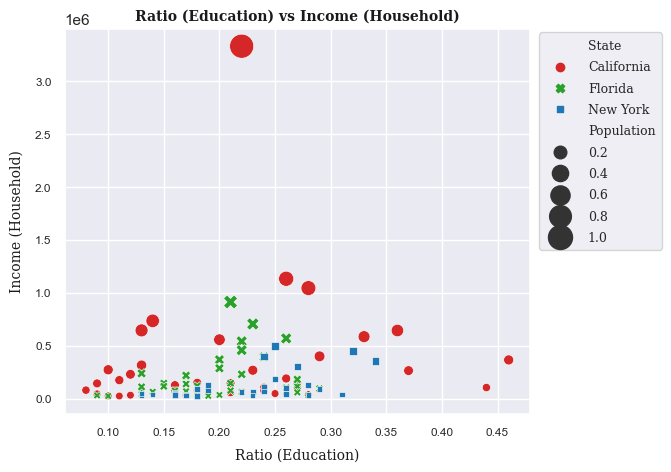

In [5]:
#%matplotlib notebook
fig, ax = plt.subplots(figsize=(6, 5))
cpalette = ["tab:red", "tab:green", "tab:blue"]
font = {'family':'serif', 'color':'k', 'weight':'normal', 'size':10, 'style':'normal'}
font_title = {'family':'serif', 'color':'k', 'weight':'bold', 'size':10, 'style':'normal'}
sc1 = sns.scatterplot(st_merged, x="Ratio", y="Household", ax=ax, palette=cpalette,
                hue="State", style="State", size="Population", sizes=(30, 300))
plt.title("Ratio (Education) vs Income (Household)", fontdict=font_title)
plt.xlabel("Ratio (Education)", fontdict=font, labelpad=8)
plt.ylabel("Income (Household)", fontdict=font, labelpad=8)
plt.xticks(fontsize=8.5)
plt.yticks(fontsize=8.5)
plt.legend(bbox_to_anchor=(1.3, 1.01), loc='upper right');
plt.setp(sc1.get_legend().get_texts(), fontsize=9, fontfamily='serif');

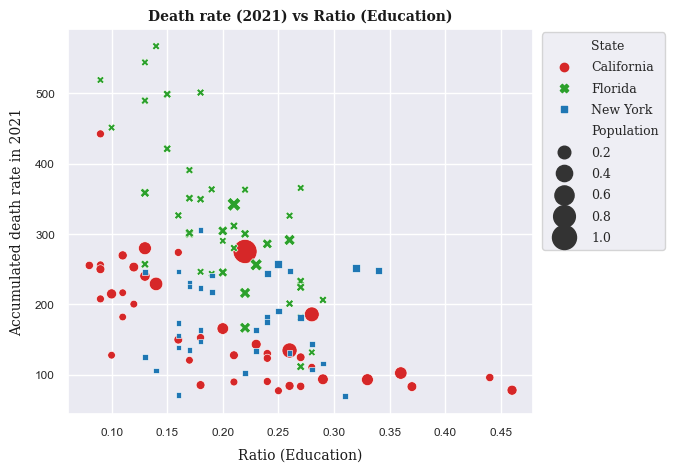

In [6]:
#%matplotlib notebook
fig, ax = plt.subplots(figsize=(6, 5))
sc2 = sns.scatterplot(st_merged, x="Ratio", y="Death_rt_2021", ax=ax, palette=cpalette,
                     hue="State", style="State", size="Population", sizes=(30, 300))
plt.title("Death rate (2021) vs Ratio (Education)", fontdict=font_title)
plt.xlabel("Ratio (Education)", fontdict=font, labelpad=8)
plt.ylabel("Accumulated death rate in 2021", fontdict=font, labelpad=8)
plt.xticks(fontsize=8.5)
plt.yticks(fontsize=8.5)
plt.legend(bbox_to_anchor=(1.3, 1.01), loc='upper right');
plt.setp(sc2.get_legend().get_texts(), fontsize=9, fontfamily='serif');

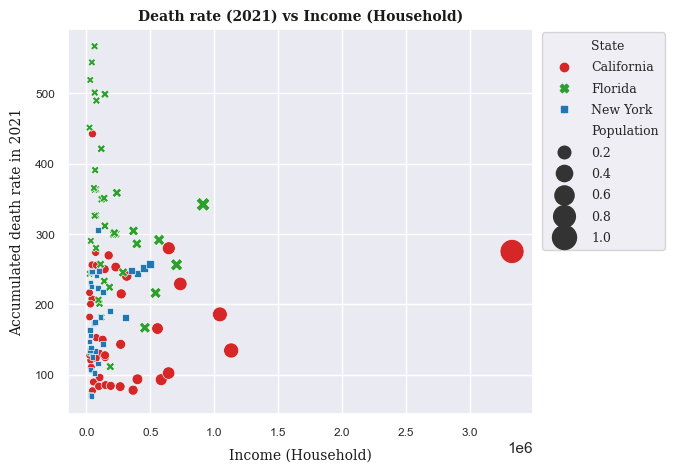

In [7]:
#%matplotlib notebook
fig, ax = plt.subplots(figsize=(6, 5))
sc3 = sns.scatterplot(st_merged, x="Household", y="Death_rt_2021", ax=ax, palette=cpalette,
                     hue="State", style="State", size="Population", sizes=(30, 300))
plt.title("Death rate (2021) vs Income (Household)", fontdict=font_title)
plt.xlabel("Income (Household)", fontdict=font, labelpad=8)
plt.ylabel("Accumulated death rate in 2021", fontdict=font, labelpad=8)
plt.xticks(fontsize=8.5)
plt.yticks(fontsize=8.5)
plt.legend(bbox_to_anchor=(1.3, 1.01), loc='upper right');
plt.setp(sc3.get_legend().get_texts(), fontsize=9, fontfamily='serif');

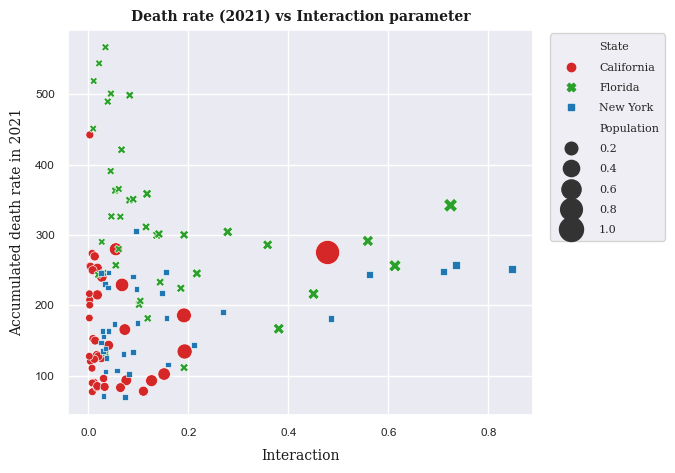

In [8]:
#%matplotlib notebook
fig, ax = plt.subplots(figsize=(6, 5))
sc3 = sns.scatterplot(st_merged, x="Interaction", y="Death_rt_2021", ax=ax, palette=cpalette,
                     hue="State", style="State", size="Population", sizes=(30, 300))
plt.title("Death rate (2021) vs Interaction parameter", fontdict=font_title)
plt.xlabel("Interaction", fontdict=font, labelpad=8)
plt.ylabel("Accumulated death rate in 2021", fontdict=font, labelpad=8)
plt.xticks(fontsize=8.5)
plt.yticks(fontsize=8.5)
plt.legend(bbox_to_anchor=(1.3, 1.01), loc='upper right');
plt.setp(sc3.get_legend().get_texts(), fontsize='8', fontfamily='serif') 
plt.setp(sc3.get_legend().get_title(), fontsize='8', fontfamily='serif');

<IPython.core.display.Javascript object>


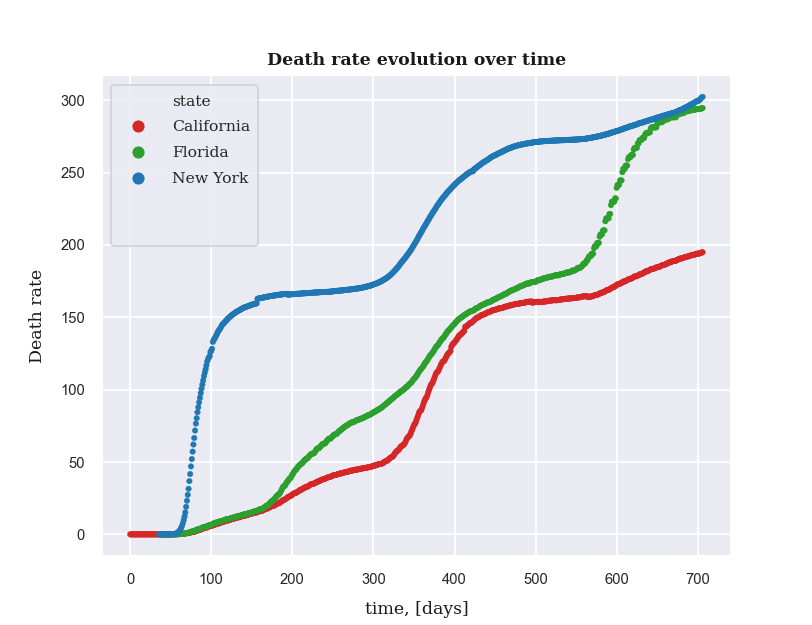

In [23]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(6.5, 5))
cv19_merged['size'] = 10
sc4 = sns.scatterplot(cv19_merged, x="day", y="death_rate", hue="state", legend='brief',
                      ax=ax, palette=cpalette, edgecolor=None, size='size', sizes=(10, 10))
plt.title("Death rate evolution over time", fontdict=font_title)
plt.xlabel("time, [days]", fontdict=font, labelpad=8)
plt.ylabel("Death rate", fontdict=font, labelpad=8)
plt.xticks(fontsize=8.5)
plt.yticks(fontsize=8.5)
plt.legend(bbox_to_anchor=(-0.0, 1.0), loc='upper left');
plt.setp(sc4.get_legend().get_texts(), fontsize=9, fontfamily='serif') 
sc4.get_legend().legendHandles[-1].set_visible(0)
sc4.get_legend().texts[-1].set_visible(0)
sc4.get_legend().texts[-2].set_visible(0)

***